In [ ]:
import gensim.downloader
import pandas as pd
import numpy as np
import torch
import random
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
import datasets
import matplotlib.pyplot as plt

# enabling inline plots in Jupyter
%matplotlib inline
datasets.logging.set_verbosity_error()

# Exercise: word embeddings

In this exercise set, we will be playing around with word embeddings. First, we will be exploring and comparing a few different pre-trained word embeddings, trained on huge data sets. We will try to vizualize some of the embeddings from one of these models in a two-dimensional space. Next, we will examine the embeddings by looking at the neighbors of some political terms. We will also look at whteher these embeddings contain any gender bias. Finally, we will train our own embeddings on a data set of speeches by Donald Trump.

# 1. Visualizing word embeddings

1. Use [Gensim](https://radimrehurek.com/gensim/) (in particular, the `gensim.downloader.load()` module) to download and import 3 GloVe word embeddings: `glove-wiki-gigaword-50`, `glove-twitter-50`, `glove-twitter-200`. The wiki-gigaword embeddings were trained on a combination of wikipedia and Gigaword corpus. The twitter embeddings were trained on a corpus of tweets. They also contain word embeddings of different lengths (50 and 200 dimensions for Twitter, 50 for wiki+gigaword).
2. Let's see what the `glove_twitter_50` embeddings look like if we try to plot them in a two-dimensional space. Complete the code below to create a [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) visualization of the 200 most common words in the corpus that the embeddings were trained on.

Hint: You can retrieve the embeddings of a list of words from a gensim embeddig model like so: `embedding[words]`. [This](https://radimrehurek.com/gensim/models/word2vec.html) documentation can help find some useful methods for the embeddings. That said, tools like Google are always useful to find necessary documentation and other resources.

In [2]:
#downloading gloves
glove_wiki_50 = gensim.downloader.load('glove-wiki-gigaword-50')
glove_twitter_50 = gensim.downloader.load('glove-twitter-50')
glove_twitter_200 = gensim.downloader.load('glove-twitter-200')

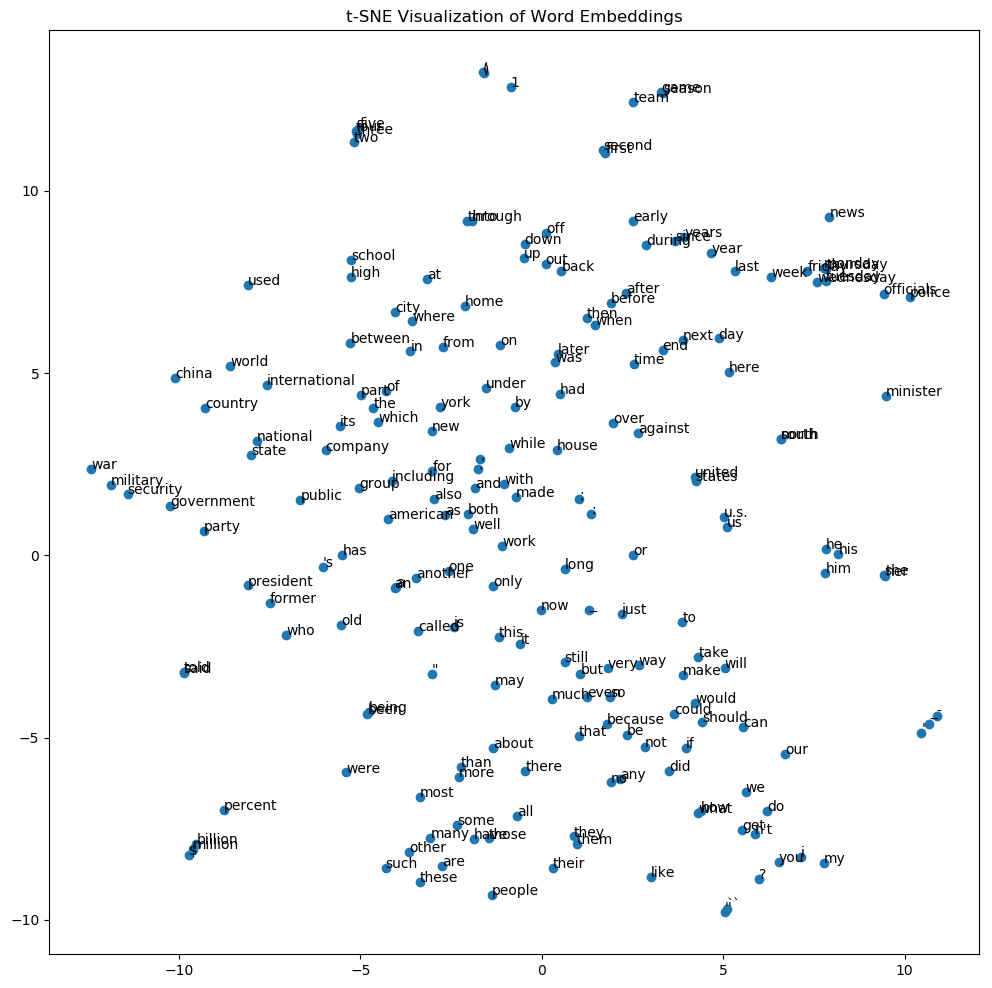

In [5]:
# let's try to see what these embeddings look like in 2D space

embedding = glove_wiki_50  # fill in the desired embedding

# Get first 200 words of words for visualization
words = list(embedding.key_to_index.keys())[:200]

# Get the corresponding vectors for the words
word_vectors = embedding[words]

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(word_vectors)

# Extract x and y coordinates
x_coords = reduced_vectors[:, 0]
y_coords = reduced_vectors[:, 1]

# Plot the embeddings
plt.figure(figsize=(12, 12))
plt.scatter(x_coords, y_coords)

# Add labels for each point
for i, word in enumerate(words):
    plt.annotate(word, (x_coords[i], y_coords[i]))

plt.title('t-SNE Visualization of Word Embeddings')
plt.show()


Even though this two-dimensional visualization does not capute the full complexity of the embeddings, we still see some promising patterns in there. For example, the cluster "war", "military" and "security", which in turn is close to other relevant words like "government", "pary" and "state".

# 2. Exploring similar words

1. Find the top 10 similar words to the word "republican" in all three models above, using the [similar_by_word](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.similar_by_word.html) method. How similar are the models? How many words in this neighborhood overlap between the two Twitter models, and the two 50-dimensional models?
2. Find what is the neighbor rank of "democrat" to "republican" in all three models (democrat is the how-manieth-closest neighbor of republican?).

In [7]:
# finding top 10 similar words to the word "republican" in all three models  
embeddings = {"glove_wiki_50":glove_wiki_50, "glove_twitter_50": glove_twitter_50, "glove_twitter_200":glove_twitter_200}

word_of_interest = "republican"
topn = 10
for e in embeddings:
    top_similar = embeddings[e].similar_by_word(word_of_interest, topn)
    top_similar = pd.DataFrame(top_similar, columns = [e, "Sim"])
    print(top_similar, "\n")

  glove_wiki_50       Sim
0           gop  0.961753
1      democrat  0.914289
2    democratic  0.911324
3   republicans  0.909894
4     democrats  0.906817
5       senator  0.891190
6        mccain  0.863955
7          dole  0.857670
8          sen.  0.852535
9        senate  0.850043 

  glove_twitter_50       Sim
0         democrat  0.947283
1       democratic  0.917992
2              gop  0.904690
3     conservative  0.887160
4      republicans  0.870593
5        democrats  0.870504
6           senate  0.852630
7          senator  0.846168
8           voters  0.841636
9            potus  0.838026 

  glove_twitter_200       Sim
0          democrat  0.862975
1               gop  0.854217
2        democratic  0.818254
3       republicans  0.808855
4         democrats  0.794788
5      conservative  0.775397
6           senator  0.742127
7     conservatives  0.712960
8            senate  0.712342
9            romney  0.700693 



We can see that in all embeddings, Democrat and related words rank very high. This is quite expected, even though the meaning is in a sense opposite to that of Republican: the words have a lot of meanings in common (US, parties, politics) and are used in a lot of similar contexts.

In [10]:

# Get the top n similar words using glove-wiki-gigaword-50 embedding
topn = 10
glove_wiki_50_topn = [x[0] for x in glove_wiki_50.similar_by_word(word_of_interest, topn)]
glove_twitter_50_topn = [x[0] for x in glove_twitter_50.similar_by_word(word_of_interest, topn)]
print("twitter-50:", glove_twitter_50_topn)
glove_twitter_200_topn = [x[0] for x in glove_twitter_200.similar_by_word(word_of_interest, topn)]

# Find the intersection of similar words between glove-twitter-50 and glove-twitter-200 embeddings
intersect_twitter = sorted([x for x in glove_twitter_50_topn if x in glove_twitter_200_topn])
intersect_50 = sorted([x for x in glove_twitter_50_topn if x in glove_wiki_50_topn])
print(f"Shared words among top {topn} neighbors of '{word_of_interest}':")
print(f"* Twitter embeddings of size 50 and 200: {' '.join(intersect_twitter)}")
print(f"* Twitter and Wiki embeddings of size 50: {' '.join(intersect_50)}")

twitter-50: ['democrat', 'democratic', 'gop', 'conservative', 'republicans', 'democrats', 'senate', 'senator', 'voters', 'potus']
Shared words among top 10 neighbors of 'republican':
* Twitter embeddings of size 50 and 200: conservative democrat democratic democrats gop republicans senate senator
* Twitter and Wiki embeddings of size 50: democrat democratic democrats gop republicans senate senator


In [20]:
# Find what is the neighbor rank of "democrat" to "republican" in all three models.
for e in embeddings:
    print(e, embeddings[e].rank("republican", "democrat"))

glove_wiki_50 2
glove_twitter_50 1
glove_twitter_200 1


# 3. Bias in embeddings

Let's investigate what our embedding models have learned about which professions are associated with which genders. Use the [most_similar](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html) method to solve analogies with the GloVe wiki + Gigaword embeddings. Follow the example below, and then insert your own professions which might be associated with one gender.

This section of the paper harks back to the, now famous, [article](https://arxiv.org/abs/1310.4546) that found the geometry of embedding vectors to mirror semantic logic, whereby vector algebra yields:

v_King - v_Man + v_Woman = v_Queen

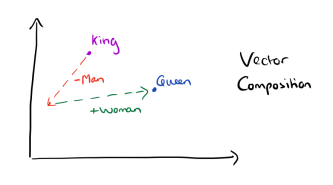

In [37]:
#this example code solves the analogy: "he is to doctor as she is to?"
glove_wiki_50.most_similar(positive=['she', 'doctor'], negative=['he'])

[('nurse', 0.8434410095214844),
 ('mother', 0.7978049516677856),
 ('child', 0.7920326590538025),
 ('woman', 0.7831878066062927),
 ('pregnant', 0.7726936936378479),
 ('girl', 0.7672077417373657),
 ('her', 0.7481821775436401),
 ('patient', 0.7464373707771301),
 ('boy', 0.7313278913497925),
 ('learns', 0.7268911600112915)]

In [38]:
#this example code solves the analogy: "man is to programmer as woman is to?"
glove_wiki_50.most_similar(positive=['woman', 'programmer'], negative=['man'])

[('prodigy', 0.6731117367744446),
 ('therapist', 0.6414064764976501),
 ('psychotherapist', 0.6201493144035339),
 ('technician', 0.6191534996032715),
 ('programmers', 0.59874427318573),
 ('educator', 0.5932906866073608),
 ('psychologist', 0.5907979607582092),
 ('installer', 0.5891358256340027),
 ('acrobat', 0.5890737771987915),
 ('indian-american', 0.5828383564949036)]

Note: there is an interesting [paper](https://arxiv.org/abs/1905.09866) by Nissim, van Noord and van der Goot (2019) criticizing the use of `gensim`'s `most_similar` analogy-solving method as a way to find bias in embeddings. They argue that first, `most_similar` is not allowed to ouput a word as a solution that is already in the query (e.g. it cannot output `programmer` in the example above). Therefore, we cannot find cases where there is no gender bias at all, where the best answer would be to fill in the same profession on both sides. Second, in light of this, it is actually unclear what a *correct, unbiased* answer to these analogies would look like.

# 4. Training your own word embeddings

Here, we will use Word2Vec to train our own embeddings on a relatively small data set of Trump's speeches during 2016 election campaign. Thus, we will capture the meaning associations between words according to Trump.

To feed this dataset into the embedding model, we will once again use a Dataloader. This time, we will create our own Dataloader class from scratch. The key part of the Dataloader is the `__iter__` method, which allows us to feed inputs to the model one chunk at a time, without loading the whole dataset into memory. This is not so important with a data set this size, but will come in handy when you work with much larger files.

1. Complete the `__iter__` method of the provided data loader class. Right now, it is set up to return one line from the file at a time. Before we return the line, though, we want to tokenize the line with a tokenizer of your choice, e.g. [word_tokenize](https://www.nltk.org/api/nltk.tokenize.word_tokenize.html) form `nltk`. We also want to lowercase it and remove any empty lines. Finally, we want to yield (output) the line in the form of a list of tokens, as that is the input format our Word2Vec model will expect.
2. Create an instance of the data loader class that uses the raw text file of speeches (`trump_speeches.txt`). The file comes from [this repository](https://github.com/ryanmcdermott/trump-speeches), distributed under "fair use".


In [65]:
# solution
class MyDataLoader(object):
    """
    A DataLoader class for reading and iterating over a corpus file.

    Args:
        filename (str): The name of the corpus file.
    """
    # initialize the corpus object for a given filename
    def __init__(self, filename):
        self.corpus = filename

    # we will need to define what counts as a "chunk" in this file, so when the
    # Dataloader is loading (iterating over) the file and feeding it to the embedding
    # model, it knows what to treat as one unit. Here, we (arbitrarily) say that one
    # line in the file (corresponding to a paragraph) is one chunk.
 
    def __iter__(self):
    # _iter_ator function to iterate over the lines of the corpus file.
        for line in open(self.corpus, "r", encoding="utf-8"):
            # checking that the line is not empty:
            if line.strip():
            # you may do some pre-processing on-the-fly. here we tokenize and lowercase
            # the string before yielding it
                line = word_tokenize(line)
                line = [x.lower() for x in line]
                yield line

In [66]:
# loading Trump speeches with the custom loader
trump_speeches = MyDataLoader("trump_speeches.txt")

3. Use Gensim to train your own Word2Vec SkipGram embeddings, using this text as a corpus. Use vector size 300, window size 3, 3 epochs. Consider the parameters listed on Gensim's [word2vec reference page](https://radimrehurek.com/gensim/models/word2vec.html).
4. Compare the nearest neighbours of "China" and "Russia" in the Trump's word2vec. How different are they? Are these representations equally reliable? Why or why not?
5. Explore your Trump embeddings with any questions you may have yourself. E.g. what words are associated with "great" for him, and what words are associated with "bad"? Ultimately, do you feel that the embeddings we are getting are meaningful or noisy?

In [67]:
# training the Skip-Gram - model
trump2vec = gensim.models.Word2Vec(
    trump_speeches,   # the larger corpus object we've loaded
    vector_size=300,     # the dimensionality of the target vectors
    window=3,     # window ngram size
    min_count=5,  # ignoring low-frequency words
    epochs=3,      # how many training passes to have
    sg = 1)       # 1 for skip-gram model, 0 for cbow

# there are waay more parameters, see the full list here:
# https://radimrehurek.com/gensim/models/word2vec.html

In [68]:
# Comparing the nearest neighbours of "China" and "Russia" in the Trump's word2vec. 
for word_of_interest in ["china", "russia"]:
    use_count = trump2vec.wv.get_vecattr(word_of_interest, "count")
    print(f"'{word_of_interest}' was mentioned {use_count} time(s) in the corpus")
    print(f"The words most similar to {word_of_interest} are:")
    print(trump2vec.wv.most_similar(word_of_interest))

'china' was mentioned 201 time(s) in the corpus
The words most similar to china are:
[('south', 0.952358603477478), ('coming', 0.9476101398468018), ('mexico', 0.94636470079422), ('communities', 0.9408704042434692), ('education', 0.9369015693664551), ('law', 0.9358603358268738), ('live', 0.9352023005485535), ('police', 0.9349479675292969), ('citizens', 0.9348612427711487), ('wealth', 0.9347256422042847)]
'russia' was mentioned 15 time(s) in the corpus
The words most similar to russia are:
[('selling', 0.9968981146812439), ('jewish', 0.9963071346282959), ('legal', 0.9962650537490845), ('theme', 0.9960685968399048), ('devastated', 0.9959602952003479), ('luck', 0.9959209561347961), ('college', 0.9958072304725647), ('late', 0.9956276416778564), ('jerry', 0.9956209659576416), ('indeed', 0.9955745935440063)]


In [11]:
for word_of_interest in ["great", "bad"]:
    use_count = trump2vec.wv.get_vecattr(word_of_interest, "count")
    print(f"'{word_of_interest}' was mentioned {use_count} time(s) in the corpus")
    print(f"The words most similar to {word_of_interest} are:")
    print(trump2vec.wv.most_similar(word_of_interest))

'great' was mentioned 687 time(s) in the corpus
The words most similar to great are:
[('again', 0.875224769115448), ('deal', 0.8437934517860413), ('america', 0.8422014713287354), ('company', 0.833357572555542), ('strong', 0.8234416842460632), ('such', 0.8229678869247437), ('job', 0.8187388181686401), ('make', 0.8166435360908508), ('deals', 0.8163862824440002), ('rich', 0.812554121017456)]
'bad' was mentioned 165 time(s) in the corpus
The words most similar to bad are:
[('too', 0.9501532912254333), ('interesting', 0.9379628896713257), ('good', 0.9324518442153931), ('really', 0.9251663088798523), ('tough', 0.9233747124671936), ('pretty', 0.9198160767555237), ('sort', 0.9153723120689392), ('here', 0.9152265787124634), ('question', 0.9118872284889221), ('sad', 0.9115636348724365)]


It looks like these embeddings contain some meaningful information; for example, China and Mexico are similar, most likely because they are two countries that Trump talked about in the same, adversarial way. And the model picked up on the phrase "Make America great again". We also once again see that opposites are placed close to each other ("bad" and "good"). Besides that, it also appears that these embeddings are noisy. We probably don't have quite enough data here to get reliable embeddings--which is why we often turn to pre-trained embeddings.